# **CS146 Linear Regression: London Housing Prices**

## **1. Loading Data**

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import pymc as pm
import arviz as az
import scipy.stats as sts

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
housing_df = pd.read_csv("/content/London.csv")

In [ ]:
# Drop Irrelevant Variables
housing_df.drop(["Unnamed: 0", "Property Name", "Postal Code", "No. of Receptions", "Location", "No. of Bedrooms", "No. of Bathrooms"], axis=1, inplace=True)
housing_df.dropna(axis=0, inplace=True)

In [ ]:
# Selecting rows where 'City/County' is 'London' and 'House Type' is 'House'
# #breakitdown to only Houses in the City of London
london_houses = housing_df[(housing_df['City/County'] == 'London') & (housing_df['House Type'] == 'House')]

In [ ]:
london_houses.head()

,Price,House Type,Area in sq ft,City/County
0,1675000,House,2716,London
3,1765000,House,1986,London
6,1475000,House,1548,London
8,2500000,House,1308,London
10,2400000,House,3392,London


In [ ]:
london_houses.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1083 entries, 0 to 3479
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Price          1083 non-null   int64 
 1   House Type     1083 non-null   object
 2   Area in sq ft  1083 non-null   int64 
 3   City/County    1083 non-null   object
dtypes: int64(2), object(2)
memory usage: 42.3+ KB


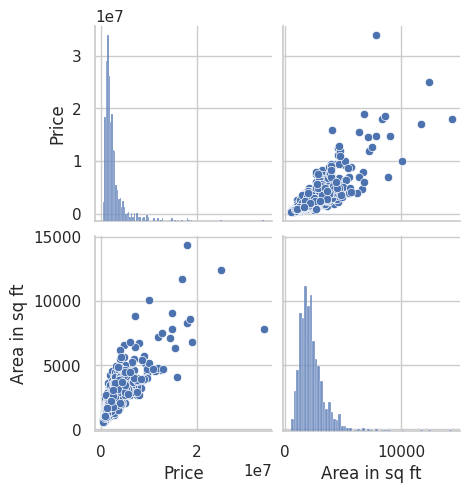

In [ ]:
london_houses = london_houses.iloc[:, [0, 2]]

# Plotting matrix of scatter plots for the quantitative variables
sns.pairplot(london_houses)
plt.show()

<ipython-input-97-0daaa8802df7>:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(


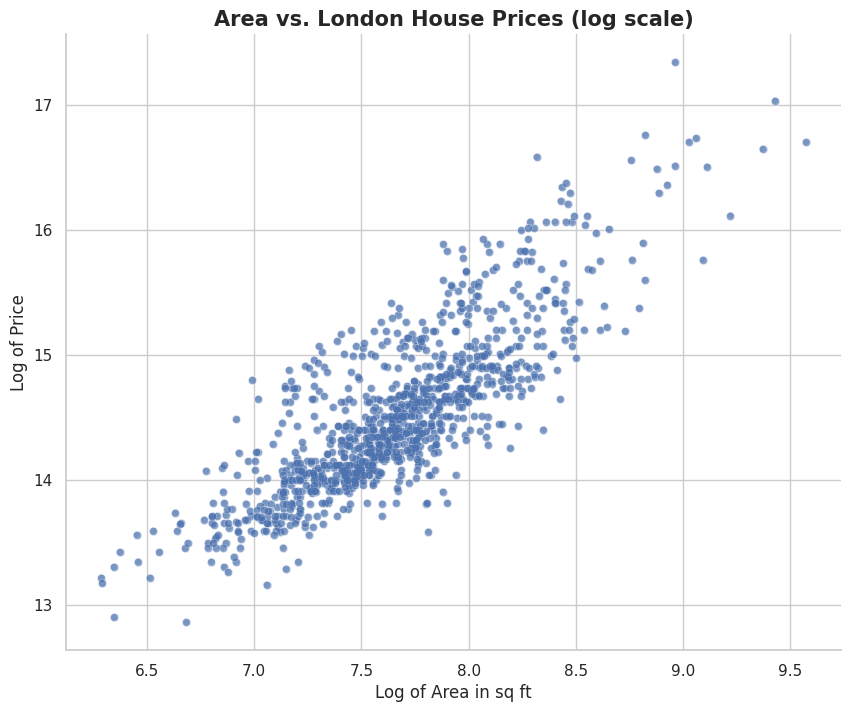

In [ ]:
# Plot our dependent and Independent Variables

sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    np.log(london_houses["Area in sq ft"]),
    np.log(london_houses["Price"]),
    alpha=0.6,
    cmap="viridis",
    edgecolors='w',
    linewidth=0.5
)

for size in range(18, 25, 2):
    plt.scatter(
        np.log(london_houses["Area in sq ft"]),
        np.log(london_houses["Price"]),
        s=size,
        alpha=0.1,
        color=scatter.get_facecolor(),
        edgecolors='none'
    )

plt.title('Area vs. London House Prices (log scale)', fontsize=15, weight='bold')
plt.xlabel('Log of Area in sq ft', fontsize=12)
plt.ylabel('Log of Price', fontsize=12)

sns.despine()

plt.show()

In [ ]:
# Apply logarithm to our data
area = np.log(london_houses['Area in sq ft'].values)
price = np.log(london_houses['Price'].values)

**Metrics**

In [ ]:
def compute_loo(model, inference):
    """
    Compute the LOO-CV score for a given Bayesian model and its inference data.

    Parameters:
    - model: A PyMC model object.
    - inference: An ArviZ InferenceData object containing the posterior samples.

    Returns:
    - loo_result: An ArviZ LOO object containing the computed LOO-CV score and related statistics.
    """

    with model:
      pm.compute_log_likelihood(inference)
    az.waic(inference, scale='deviance')

    # Calculate PSIS LOO-CV score
    loo_result = az.loo(inference, scale='deviance')

    # Print the result
    print(loo_result)

## **2. Create Models**

Note: The code below produced plots for degree 1 and 2 polynomials only because it is more time efficient. However, degree 3 polynomials were also produced with no significant improvement in degree of fit but an unjustified increase in complexity, with extremely poor sampling diagnostic results. By adjusting degree of polynomial in the code cell below, higher order polynomials might be produced and checked for fit.

### **Normal likelihood function**

In [ ]:
normal_models = []

In [ ]:
def polynomial_normal_model(degree):
    with pm.Model() as model:

        # Priors for the model parameters
        intercept = pm.Uniform('intercept', lower=0, upper=np.log(50000000))
        sigma = pm.Uniform('sigma', lower=0, upper=np.log(20000000))

        # Mutable data for the observed variables
        area_data = pm.MutableData('area', area)
        price_data = pm.MutableData('price', price)

        # Construct polynomial terms dynamically
        mu = intercept
        for i in range(1, degree + 1):
            coeff = pm.Normal(f'slope_{i}', mu=0, sigma=np.log(200))
            mu += coeff * area_data ** i

        mu = pm.Deterministic('mu', mu)

        # Likelihood (sampling distribution) of observations
        pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=price_data)

        # Posterior sampling
        inference = pm.sample(1000, return_inferencedata=True)

    return model, inference

For the intercept of the model, a Uniform distribution ranging from £0 to the logarithm of £50,000,000 was selected. This range was chosen to reflect the wide variance in property values across London, from the most modest to the most luxurious estates. Using a log scale for the upper limit accommodates the exponential price increase at the higher end of the market, ensuring the model can capture the base price of properties across this spectrum. The lower bound at £0, in the context of log-transformed prices, implies a small but non-zero value in real terms, acknowledging the economic reality that no property would have zero value.

The model's `sigma` parameter, representing the standard deviation of the residuals, was also assigned a Uniform prior with bounds from 0 to the logarithm of £20,000,000. This broad range allows the model to account for the significant variability in house prices that the area alone cannot explain. Location desirability, property condition, and temporal market fluctuations contribute to this variability. The wide prior range for `sigma` ensures that the model remains flexible enough to capture the inherent unpredictability in the housing market.

Normal distributions centered at £0 with a standard deviation set to the logarithm of £200 were employed for the slope coefficients associated with each degree of the polynomial terms. This prior specification suggests a balanced expectation for the impact of the area on price, allowing for both positive and negative effects. Given the polynomial nature of the model, these priors accommodate the potential complexity and non-linearity of the relationship between area and price.

In [ ]:
for degree in range(1, 3):
    model, inference = polynomial_normal_model(degree)
    normal_models.append((degree, model, inference))

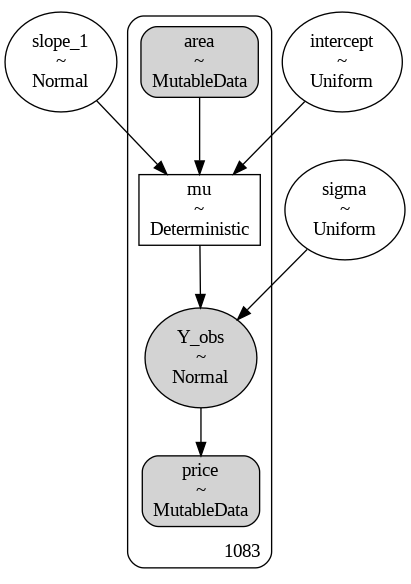

In [ ]:
from IPython.display import Image
Image(pm.model_to_graphviz(normal_models[0][1]).render(format='png'))

Model Degree: 1
            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept  5.673  0.171   5.362    6.000      0.006    0.005     722.0   
sigma      0.358  0.007   0.344    0.372      0.000    0.000     916.0   
slope_1    1.154  0.022   1.113    1.197      0.001    0.001     721.0   

           ess_tail  r_hat  
intercept     673.0    1.0  
sigma         852.0    1.0  
slope_1       612.0    1.0  
Model Degree: 2
             mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept  15.507  1.425  13.130   17.717      0.081    0.057     309.0   
sigma       0.354  0.008   0.339    0.367      0.000    0.000     545.0   
slope_1    -1.402  0.369  -1.992   -0.789      0.021    0.015     312.0   
slope_2     0.165  0.024   0.125    0.205      0.001    0.001     315.0   

           ess_tail  r_hat  
intercept     328.0   1.00  
sigma         421.0   1.01  
slope_1       393.0   1.00  
slope_2       405.0   1.00  


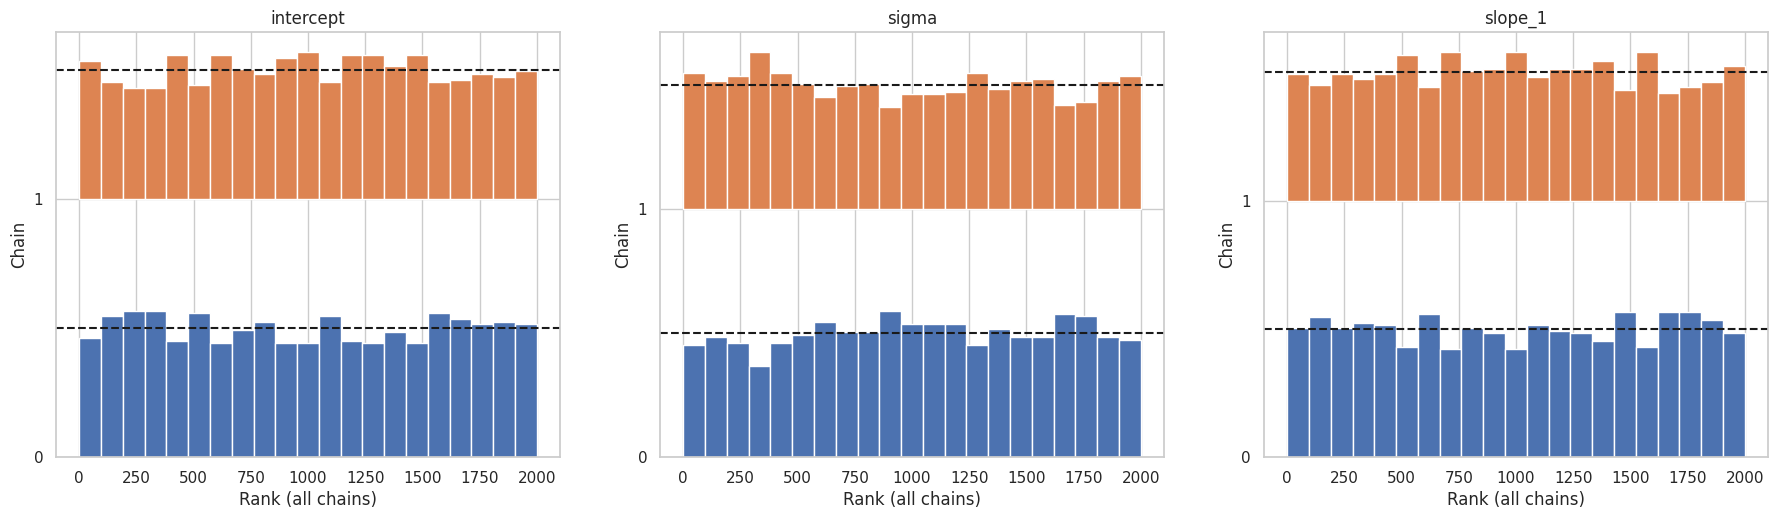

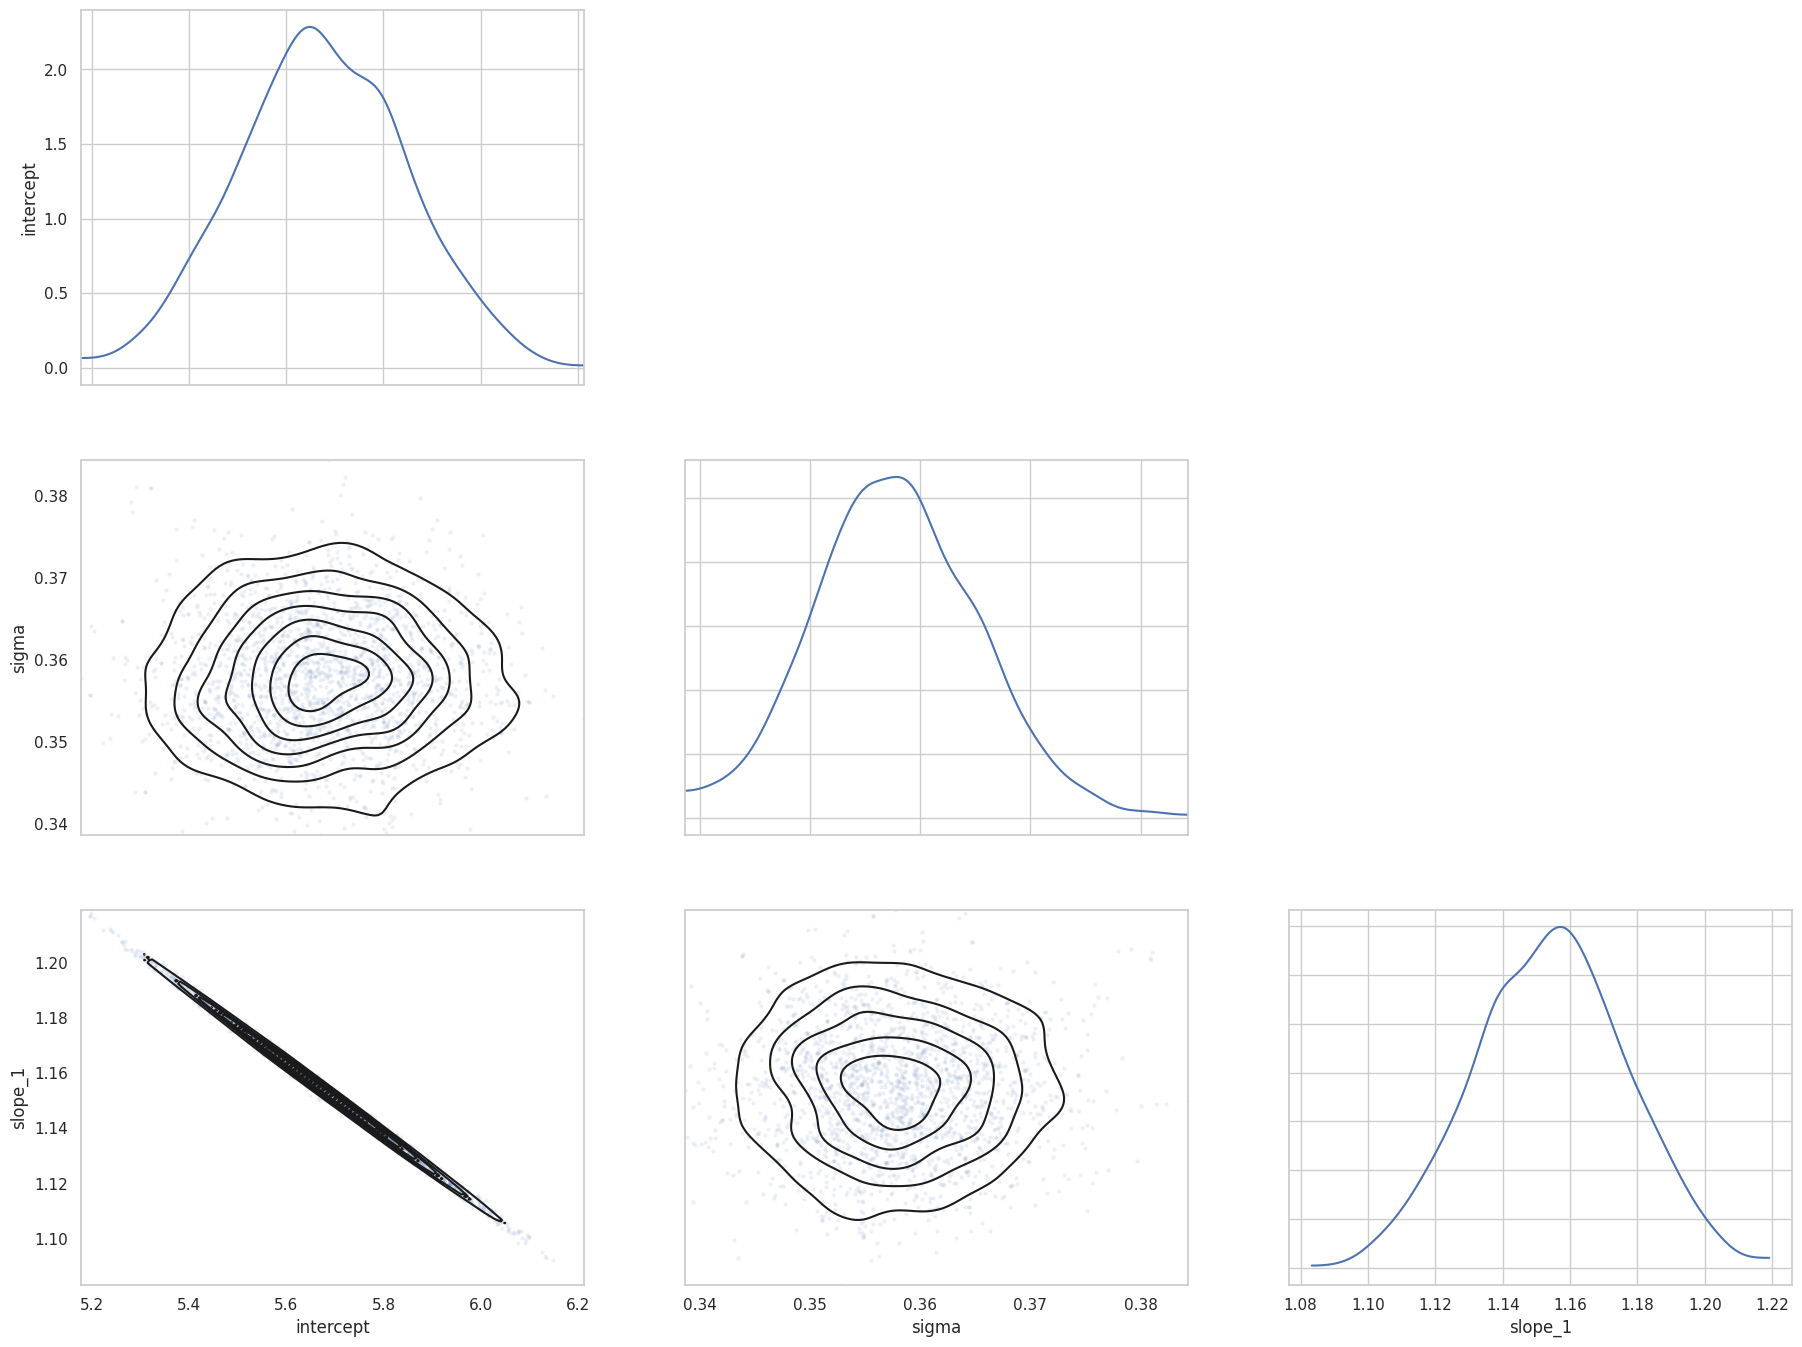

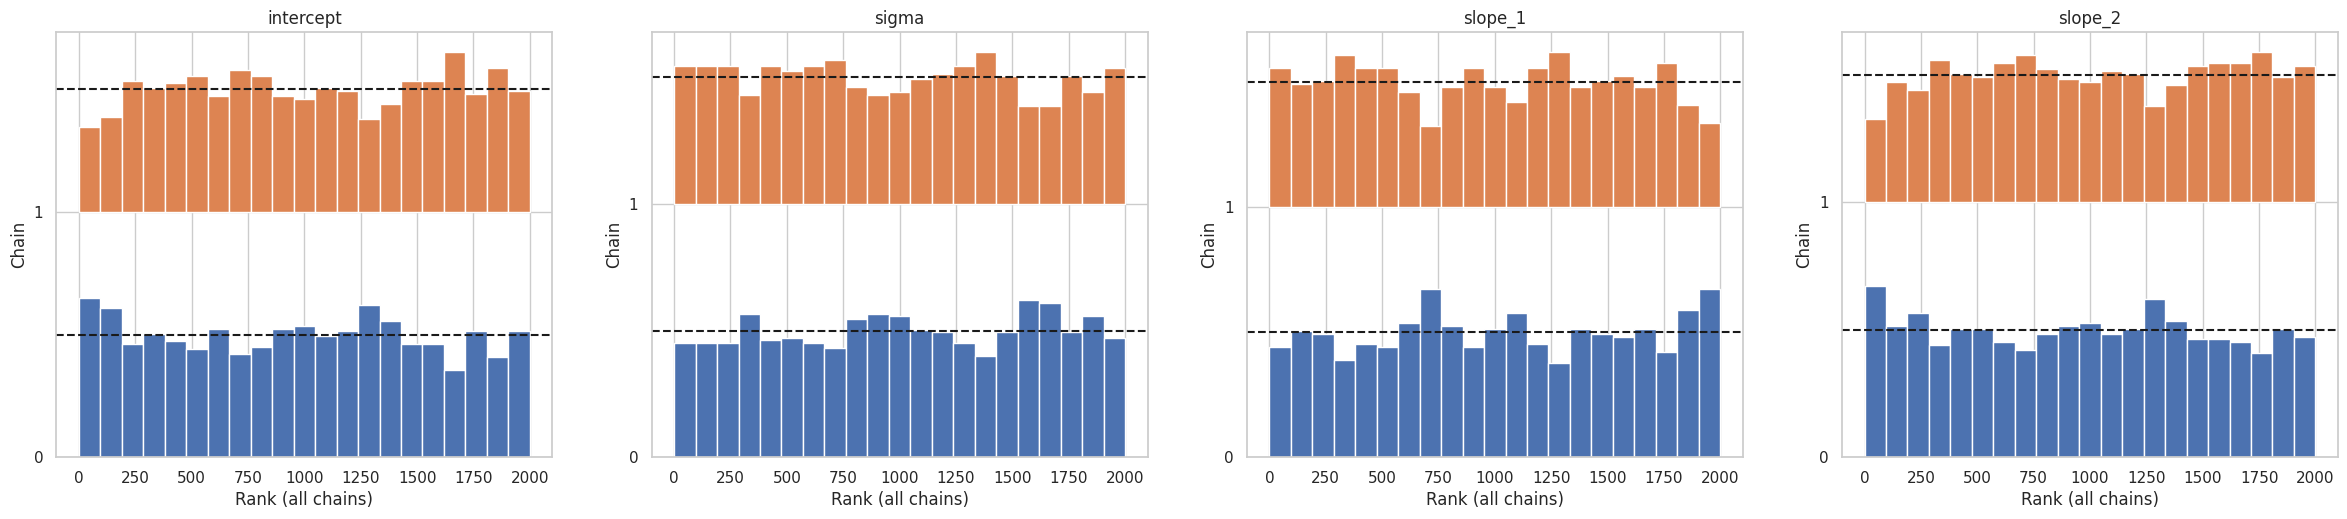

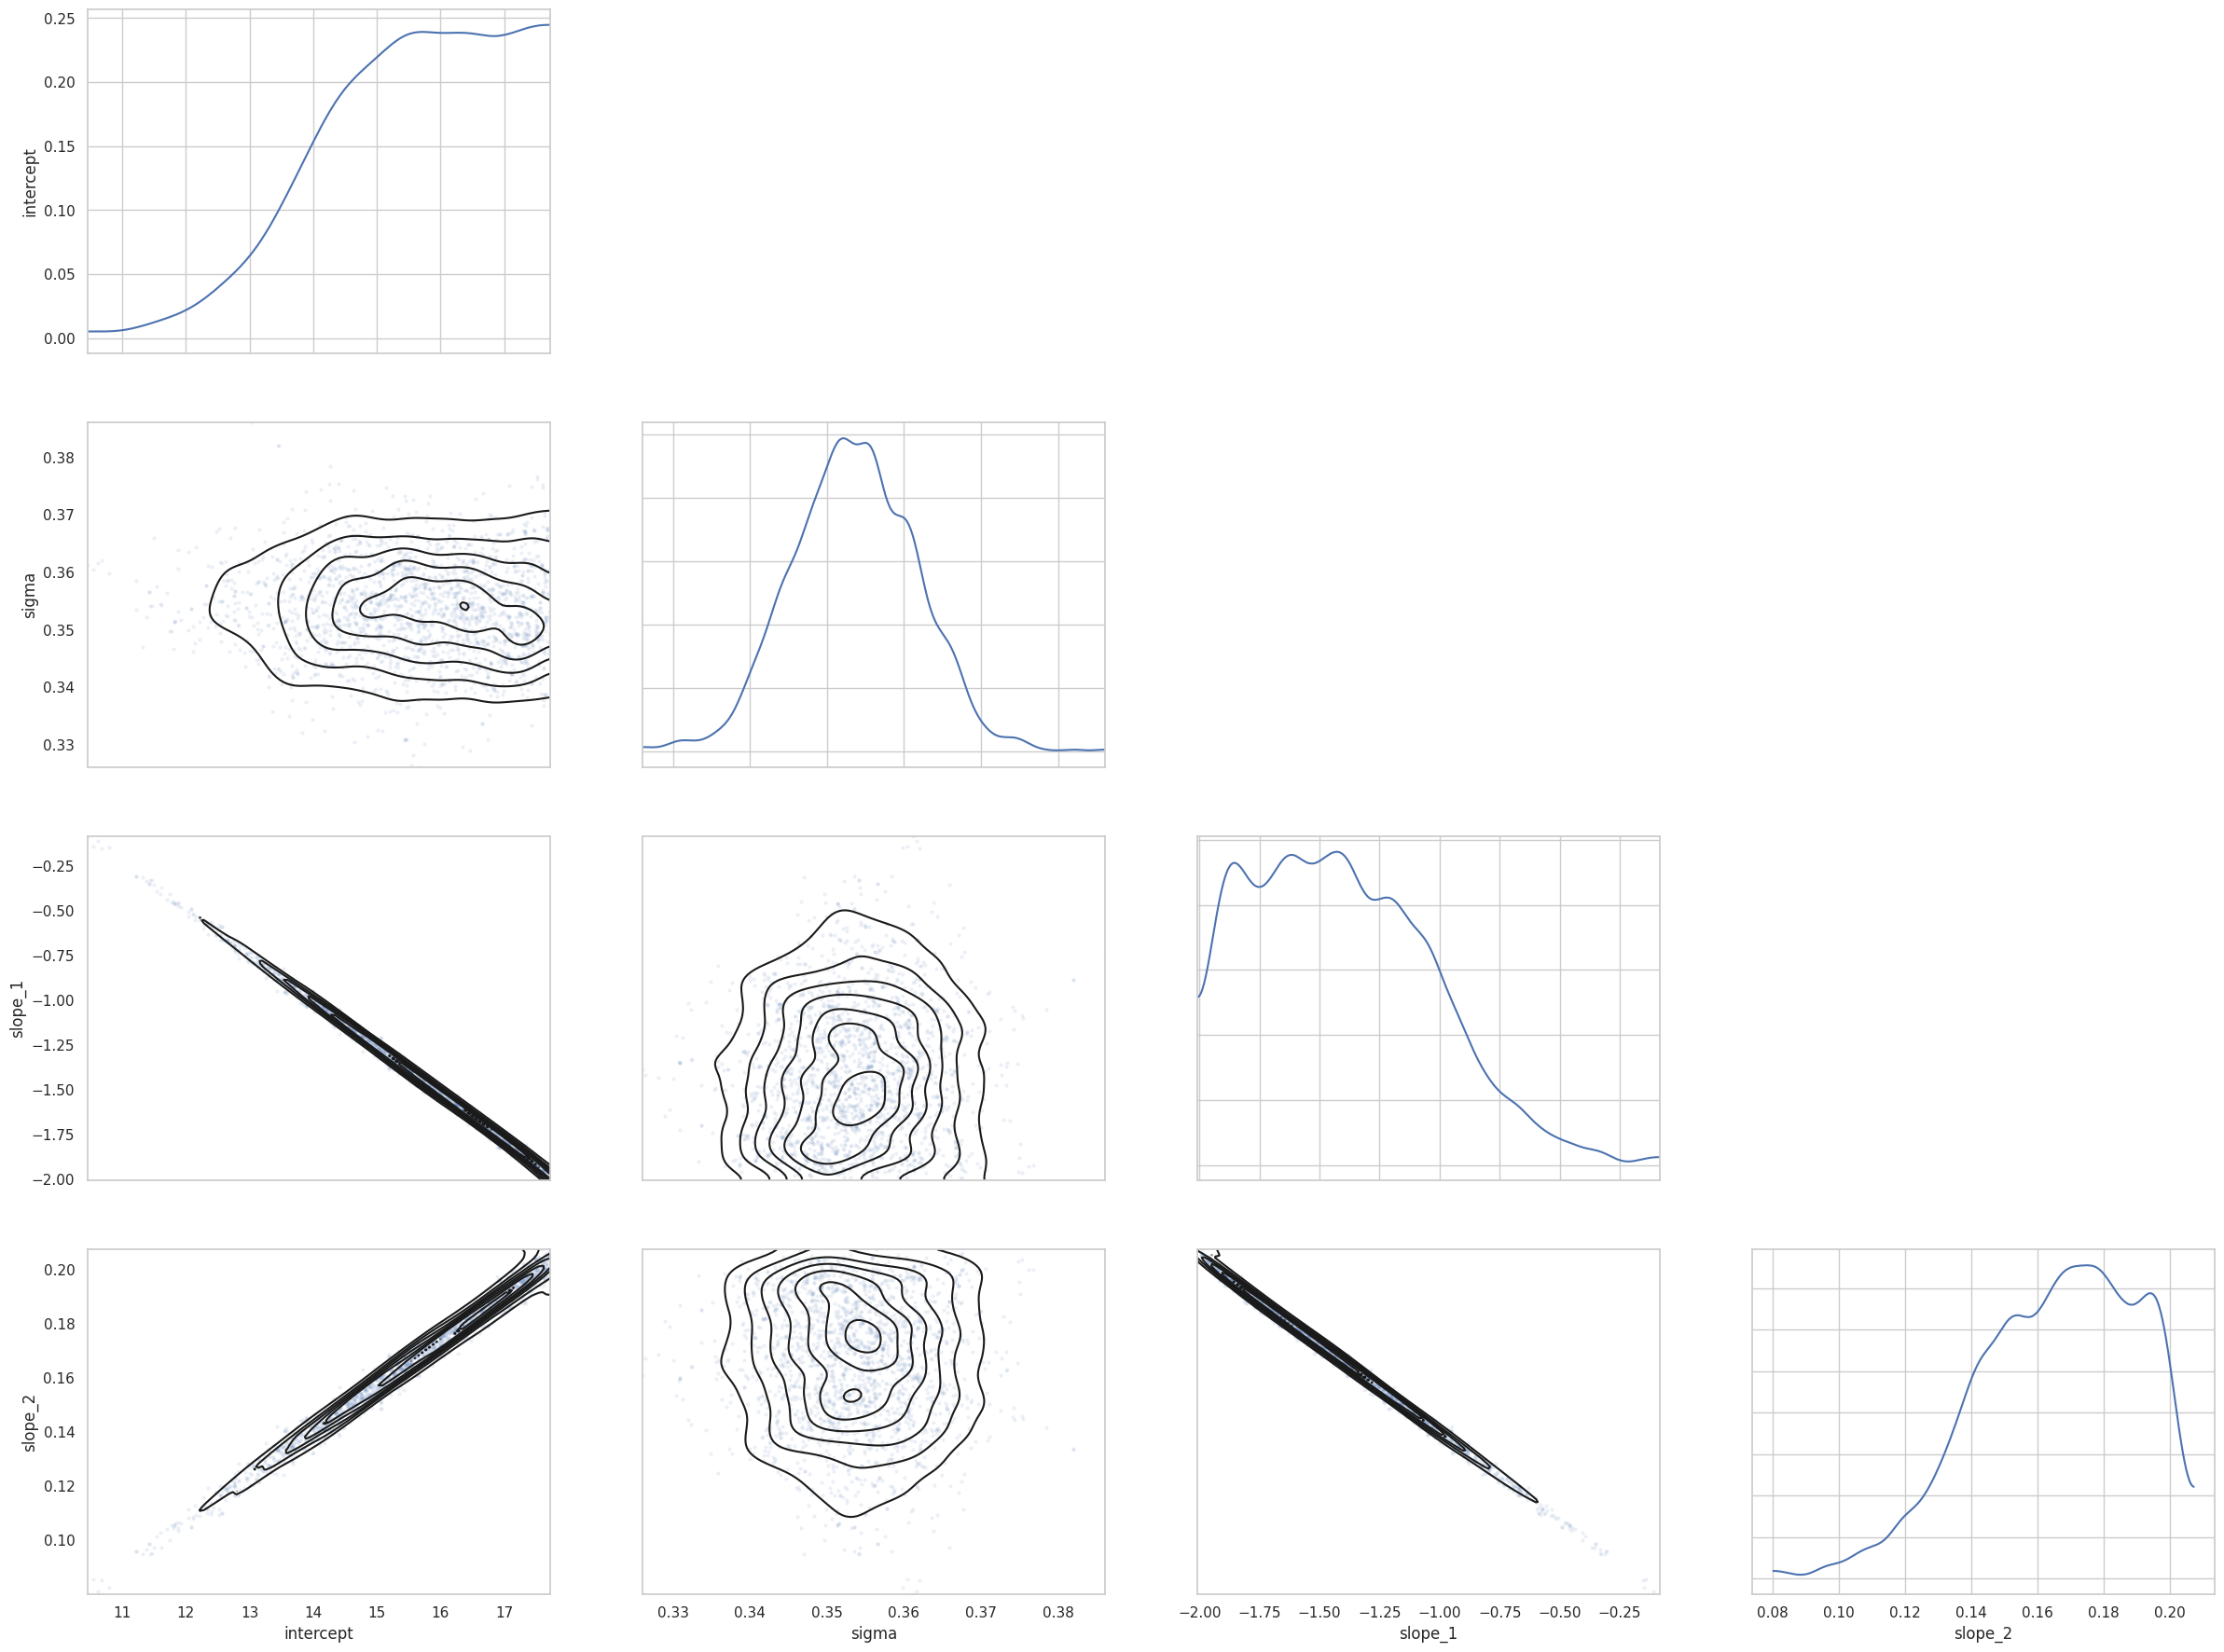

In [ ]:
# Loop through models stored in normal_models for diagnostics
for degree, model, inference in normal_models:
    print(f"Model Degree: {degree}")

    # Diagnostic plots and summary for each model degree
    # Adjust var_names dynamically based on the degree of the polynomial model
    var_names = ['intercept', 'sigma'] + [f'slope_{i}' for i in range(1, degree + 1)]

    # Plot rank
    az.plot_rank(inference, var_names=var_names)

    # Summary statistics
    summary = az.summary(inference, var_names=var_names)
    print(summary)

    # Pair plot
    az.plot_pair(inference,
                 marginals=True,
                 var_names=var_names,
                 kind=["scatter", "kde"],
                 scatter_kwargs={"color": "C0", "alpha": 0.1},
                 marginal_kwargs={"kind": "kde", "color": "C0"},
                 kde_kwargs={"contour_kwargs": {"colors": "k", 'alpha': 1}})

For the degree 1 polynomial, the r_hat values are appropriately around 1, the ess values are high showing both bulk of data and tails are well-sampled from independently, also reflected in the histograms which reflect a uniform distribution close to the expected (dotted line). The pair plots also show normally distributed sampled variables. There is a negative relation between intercept and slope as when intercept increase, more of a price point's value is being contributed by the intercept than the slope.

While the r_hat for the degree 2 polynomial are still around 1, the ess are low, which together with the uneveness of the samples shows that the samples were non-independent and likely do not reflect the underlying distribution of the data. So while degree 2 offers us a better fit, it is also likely true that there is a lot more uncertainty in regards to their distribution and might give us errors in regards to the true Maximum Likelhood Estimates's to be used in a predictive model.

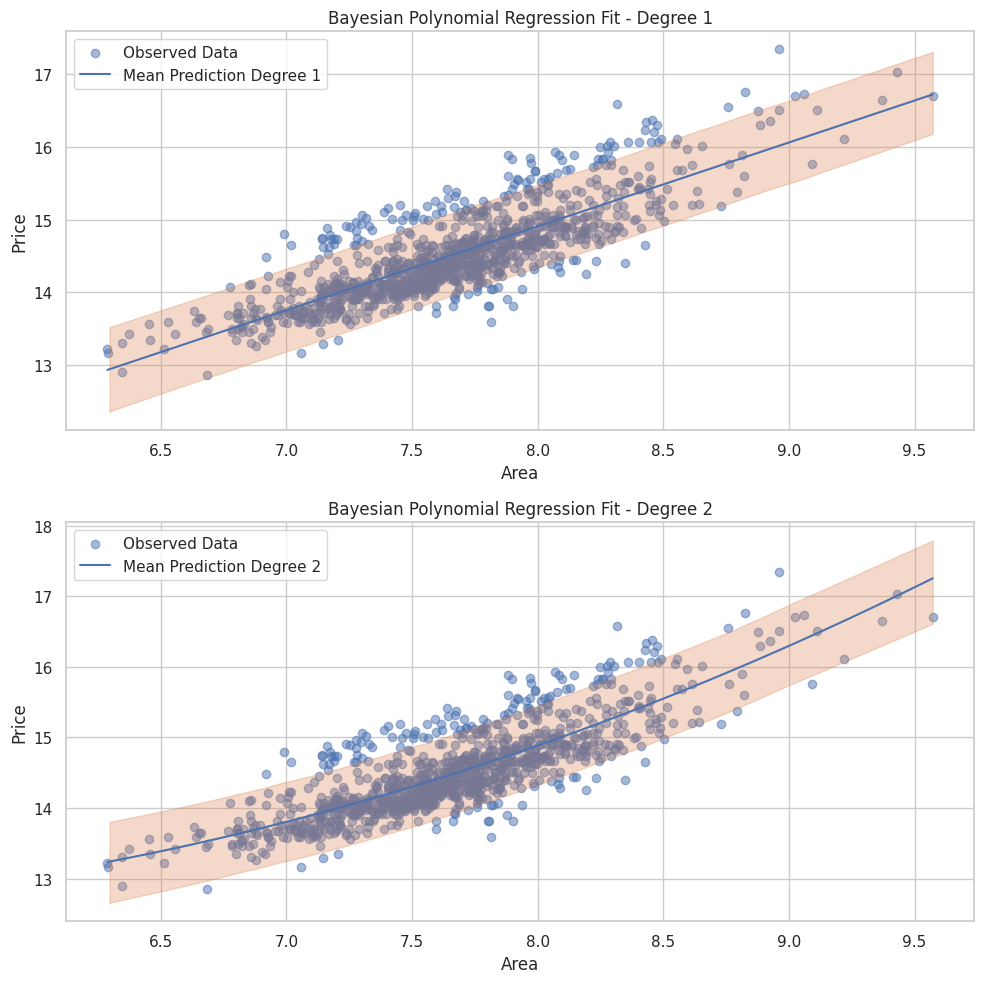

In [ ]:
# Generate a sequence of areas for plotting, covering the observed range
area_seq = np.linspace(area.min(), area.max(), 100)

# Function to calculate expected price for polynomial models
def calculate_expected_price(degree, area_seq, inference):
    intercept_mean = inference.posterior["intercept"].mean().values.item()  # Ensure scalar
    expected_price_seq = intercept_mean
    for i in range(1, degree + 1):
        slope_mean = inference.posterior[f"slope_{i}"].mean().values.item()  # Ensure scalar
        expected_price_seq += slope_mean * np.power(area_seq, i)
    return expected_price_seq

# Determine the number of subplots needed
num_models = len(normal_models)

# Create subplots
fig, axs = plt.subplots(num_models, 1, figsize=(10, 5 * num_models))

# Ensure axs is an array even if there's only one subplot
if num_models == 1:
    axs = [axs]

# Loop through stored models and inferences for plotting
for idx, (degree, model, inference) in enumerate(normal_models):
    with model:
        # Generate posterior predictive checks
        posterior_pred = pm.sample_posterior_predictive(inference, var_names=["Y_obs"])

    expected_price_seq = calculate_expected_price(degree, area_seq, inference)

    # Plot observed data
    axs[idx].scatter(area, price, alpha=0.5, label="Observed Data")
    # Plot mean prediction for each degree
    axs[idx].plot(area_seq, expected_price_seq, label=f"Mean Prediction Degree {degree}")
    # Plot HDI for posterior predictive for the current degree model
    az.plot_hdi(area, posterior_pred.posterior_predictive["Y_obs"], hdi_prob=0.89, fill_kwargs={"alpha": 0.3}, ax=axs[idx])

    axs[idx].set_xlabel("Area")
    axs[idx].set_ylabel("Price")
    axs[idx].set_title(f"Bayesian Polynomial Regression Fit - Degree {degree}")
    axs[idx].legend()

plt.tight_layout()
plt.show()

In [ ]:
for degree, model, inference in normal_models:
    compute_loo(model, inference)

<ipython-input-99-b0673da29fde>:15: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  az.waic(inference, scale='deviance')
<ipython-input-99-b0673da29fde>:18: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  loo_result = az.loo(inference, scale='deviance')


Computed from 2000 posterior samples and 1083 observations log-likelihood matrix.

             Estimate       SE
deviance_loo   852.21    53.04
p_loo            3.28        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     1083  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



<ipython-input-99-b0673da29fde>:15: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  az.waic(inference, scale='deviance')
<ipython-input-99-b0673da29fde>:18: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  loo_result = az.loo(inference, scale='deviance')


Computed from 2000 posterior samples and 1083 observations log-likelihood matrix.

             Estimate       SE
deviance_loo   823.87    53.51
p_loo            4.38        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     1083  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



### **Student T-Distribution Model**

In [ ]:
t_models = []

In [ ]:
def polynomial_t_model(degree, area, price):
    with pm.Model() as model:
        # Priors for the model parameters
        intercept = pm.Uniform('intercept', lower=0, upper=np.log(50000000))
        sigma = pm.Uniform('sigma', lower=0, upper=np.log(20000000))

        # Degrees of freedom for the Student's t-distribution
        nu = pm.HalfNormal('nu', sigma=np.log(15))

        # Mutable data for the observed variables
        area_data = pm.MutableData('area', area)
        price_data = pm.MutableData('price', price)

        # Construct polynomial terms dynamically
        mu = intercept
        for i in range(1, degree + 1):
            coeff = pm.Normal(f'slope_{i}', mu=0, sigma=np.log(200))
            mu += coeff * area_data ** i

        # Expected value of outcome
        mu = pm.Deterministic('mu', mu)

        # Likelihood (sampling distribution) of observations using a Student T distribution
        pm.StudentT('Y_obs', nu=nu, mu=mu, sigma=sigma, observed=price_data)

        # Posterior sampling
        inference = pm.sample(1000, return_inferencedata=True)

    return model, inference

In addition to the priors discussed above, nu is modeled as following a HalfNormal distribution with a standard deviation set to the logarithm of 15. This choice reflects a balance between flexibility and constraint, allowing for a heavier-tailed distribution than a normal distribution but not so broad as to make the model overly sensitive to outliers. The HalfNormal distribution is selected because it ensures that no takes on only positive values, in line with the theoretical requirements for degrees of freedom in a t-distribution, which must be greater than zero.

In [ ]:
for degree in range(1, 3):
    model, inference = polynomial_t_model(degree, area, price)  # Create the t-model for each degree
    t_models.append((degree, model, inference))

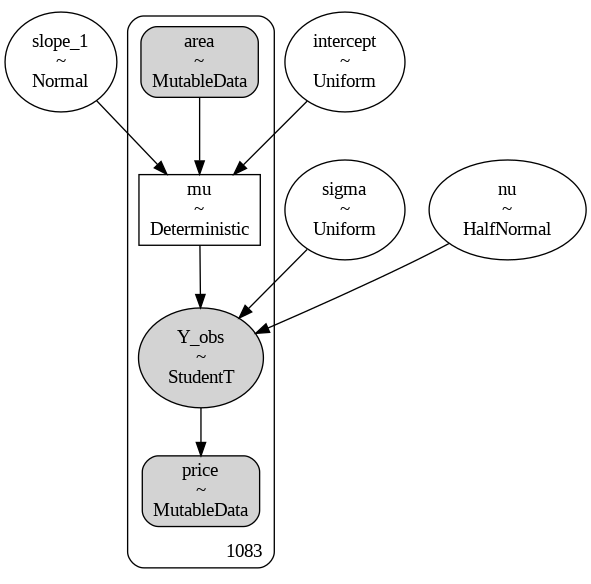

In [ ]:
from IPython.display import Image
Image(pm.model_to_graphviz(t_models[0][1]).render(format='png'))

Model Degree: 1
            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept  5.881  0.172   5.566    6.208      0.007    0.005     639.0   
sigma      0.276  0.013   0.251    0.301      0.000    0.000     727.0   
nu         4.305  0.774   2.993    5.697      0.029    0.020     745.0   
slope_1    1.121  0.023   1.076    1.160      0.001    0.001     638.0   

           ess_tail  r_hat  
intercept     822.0    1.0  
sigma         921.0    1.0  
nu            977.0    1.0  
slope_1       829.0    1.0  
Model Degree: 2
             mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept  16.458  0.852  15.009   17.727      0.082    0.058     112.0   
sigma       0.261  0.013   0.236    0.283      0.001    0.000     523.0   
nu          3.792  0.663   2.772    5.014      0.033    0.025     487.0   
slope_1    -1.654  0.224  -2.008   -1.279      0.021    0.015     123.0   
slope_2     0.181  0.015   0.155    0.205      0.001    0.001     131.0   

 

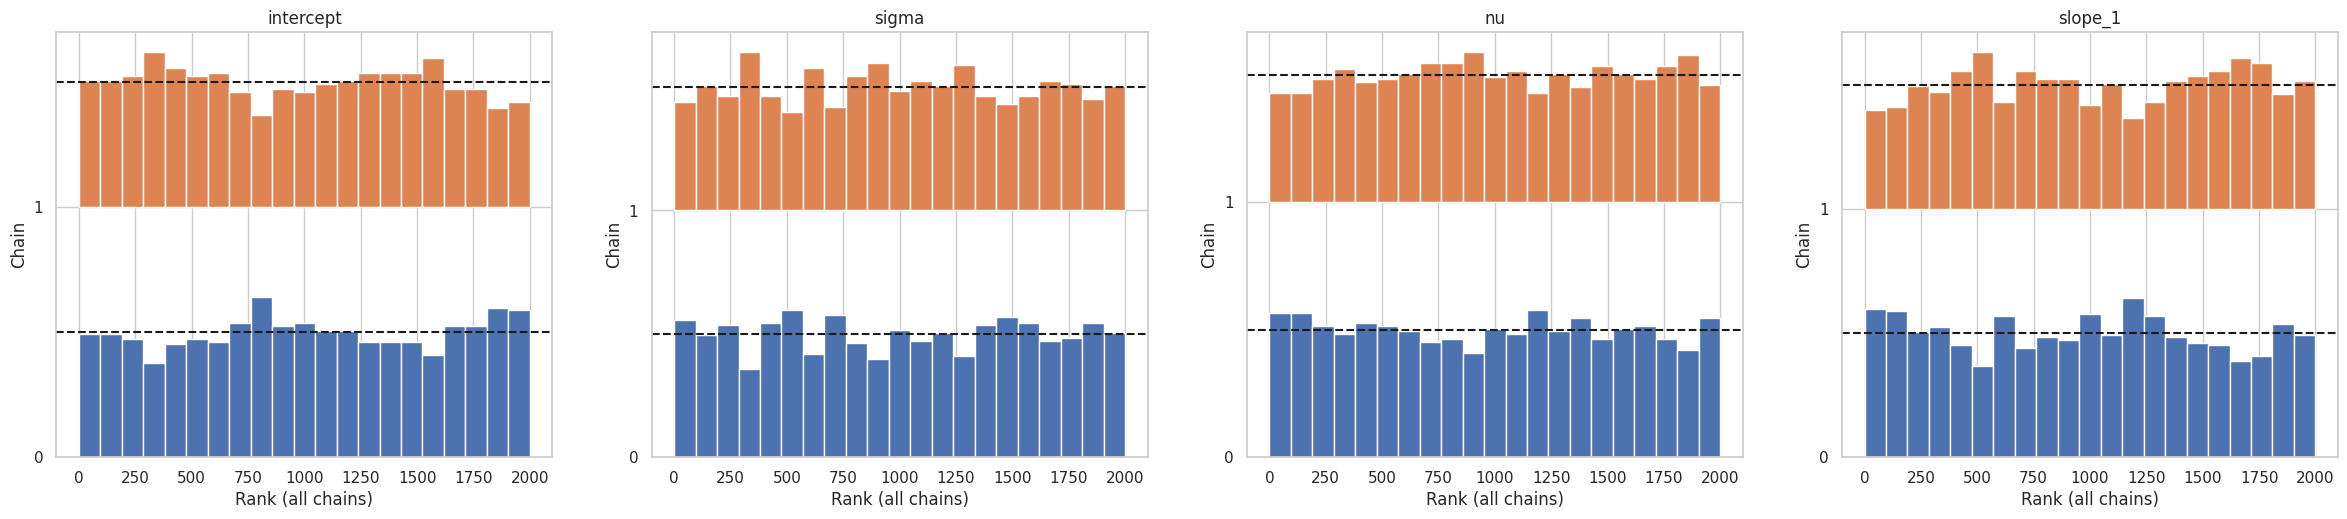

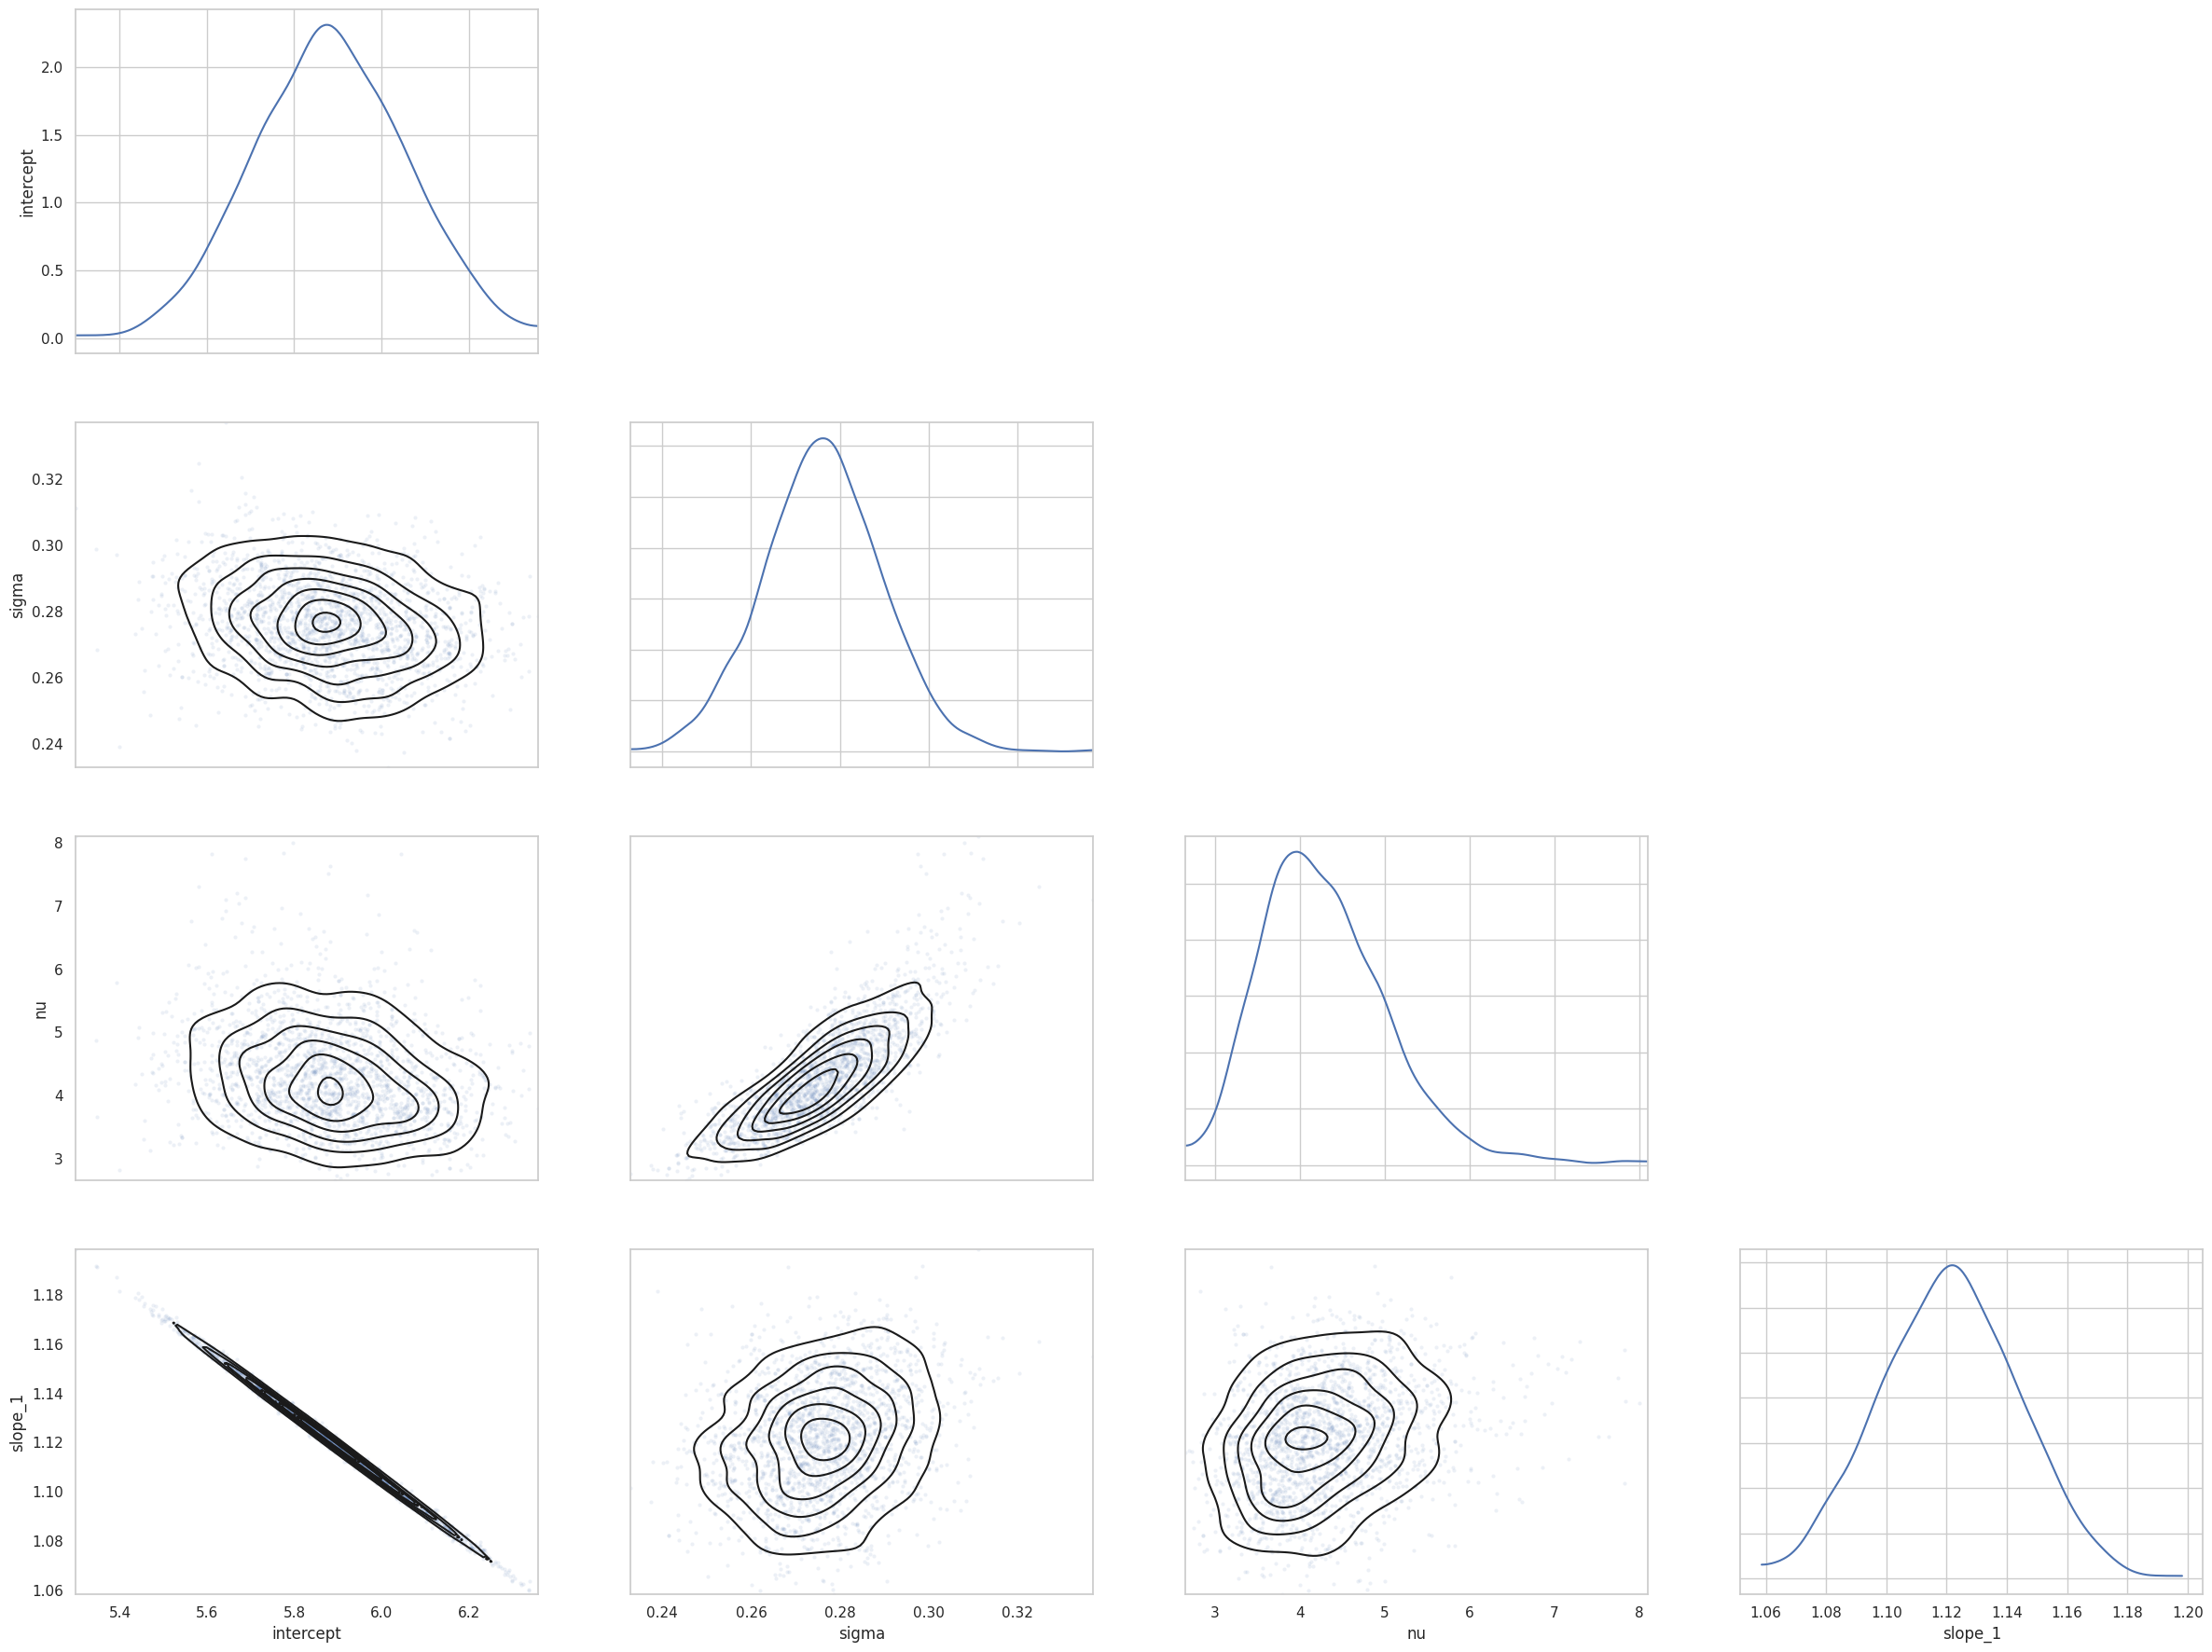

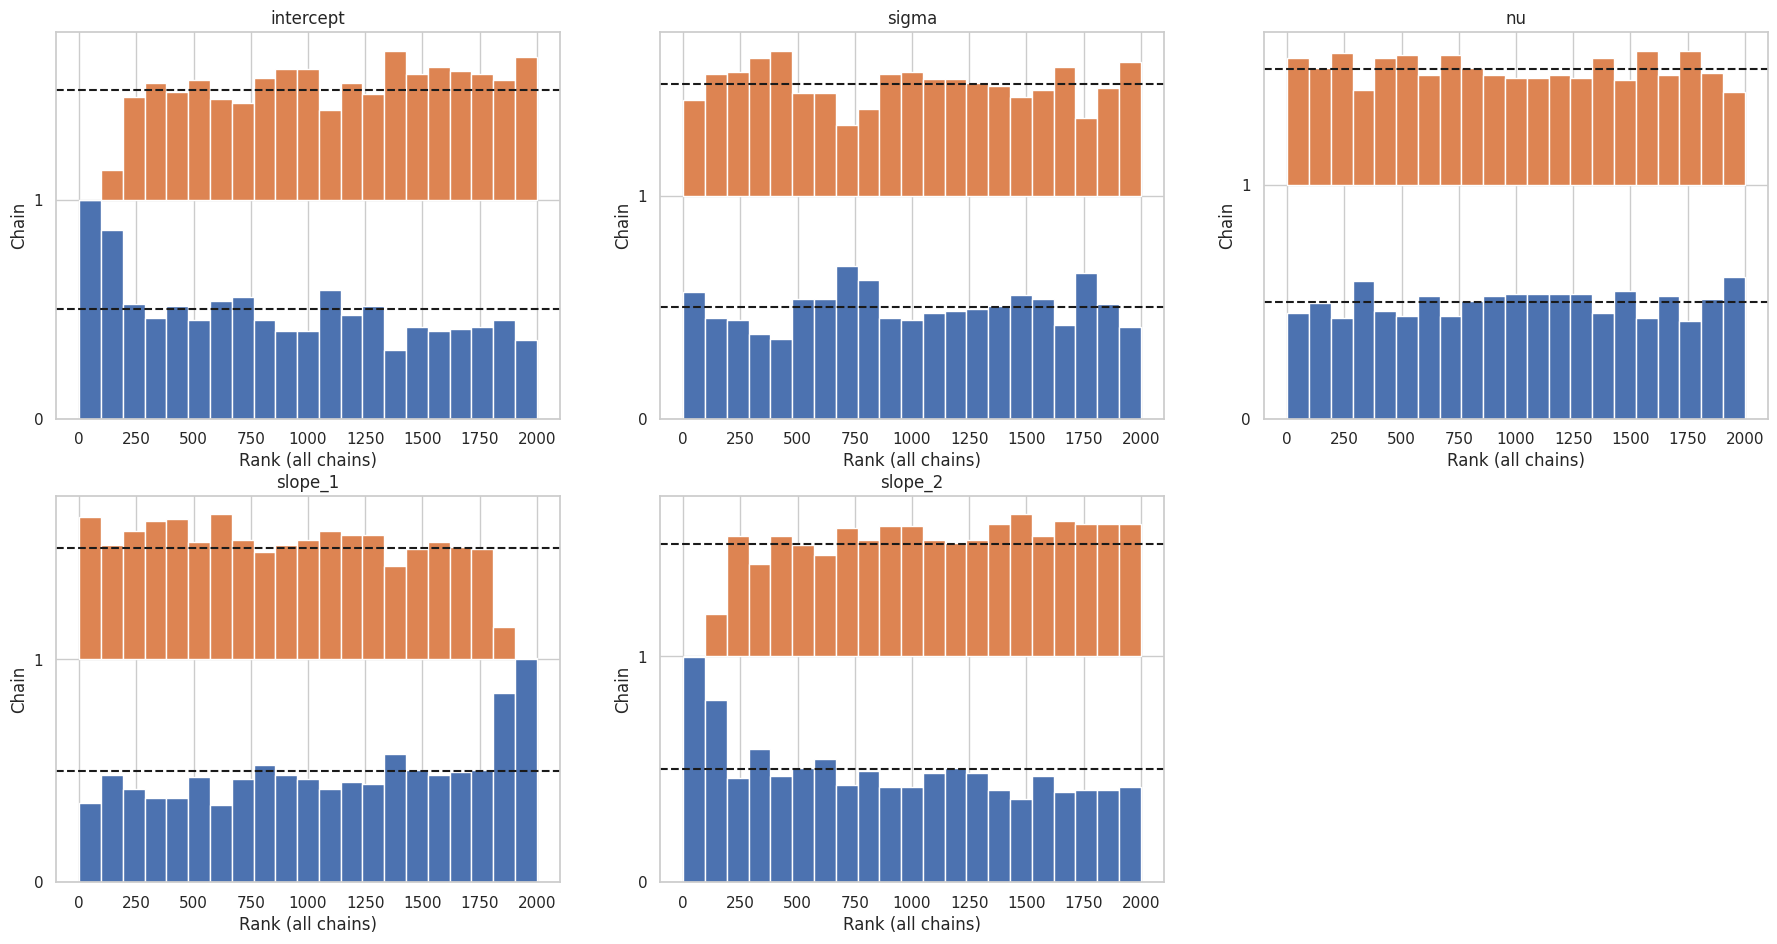

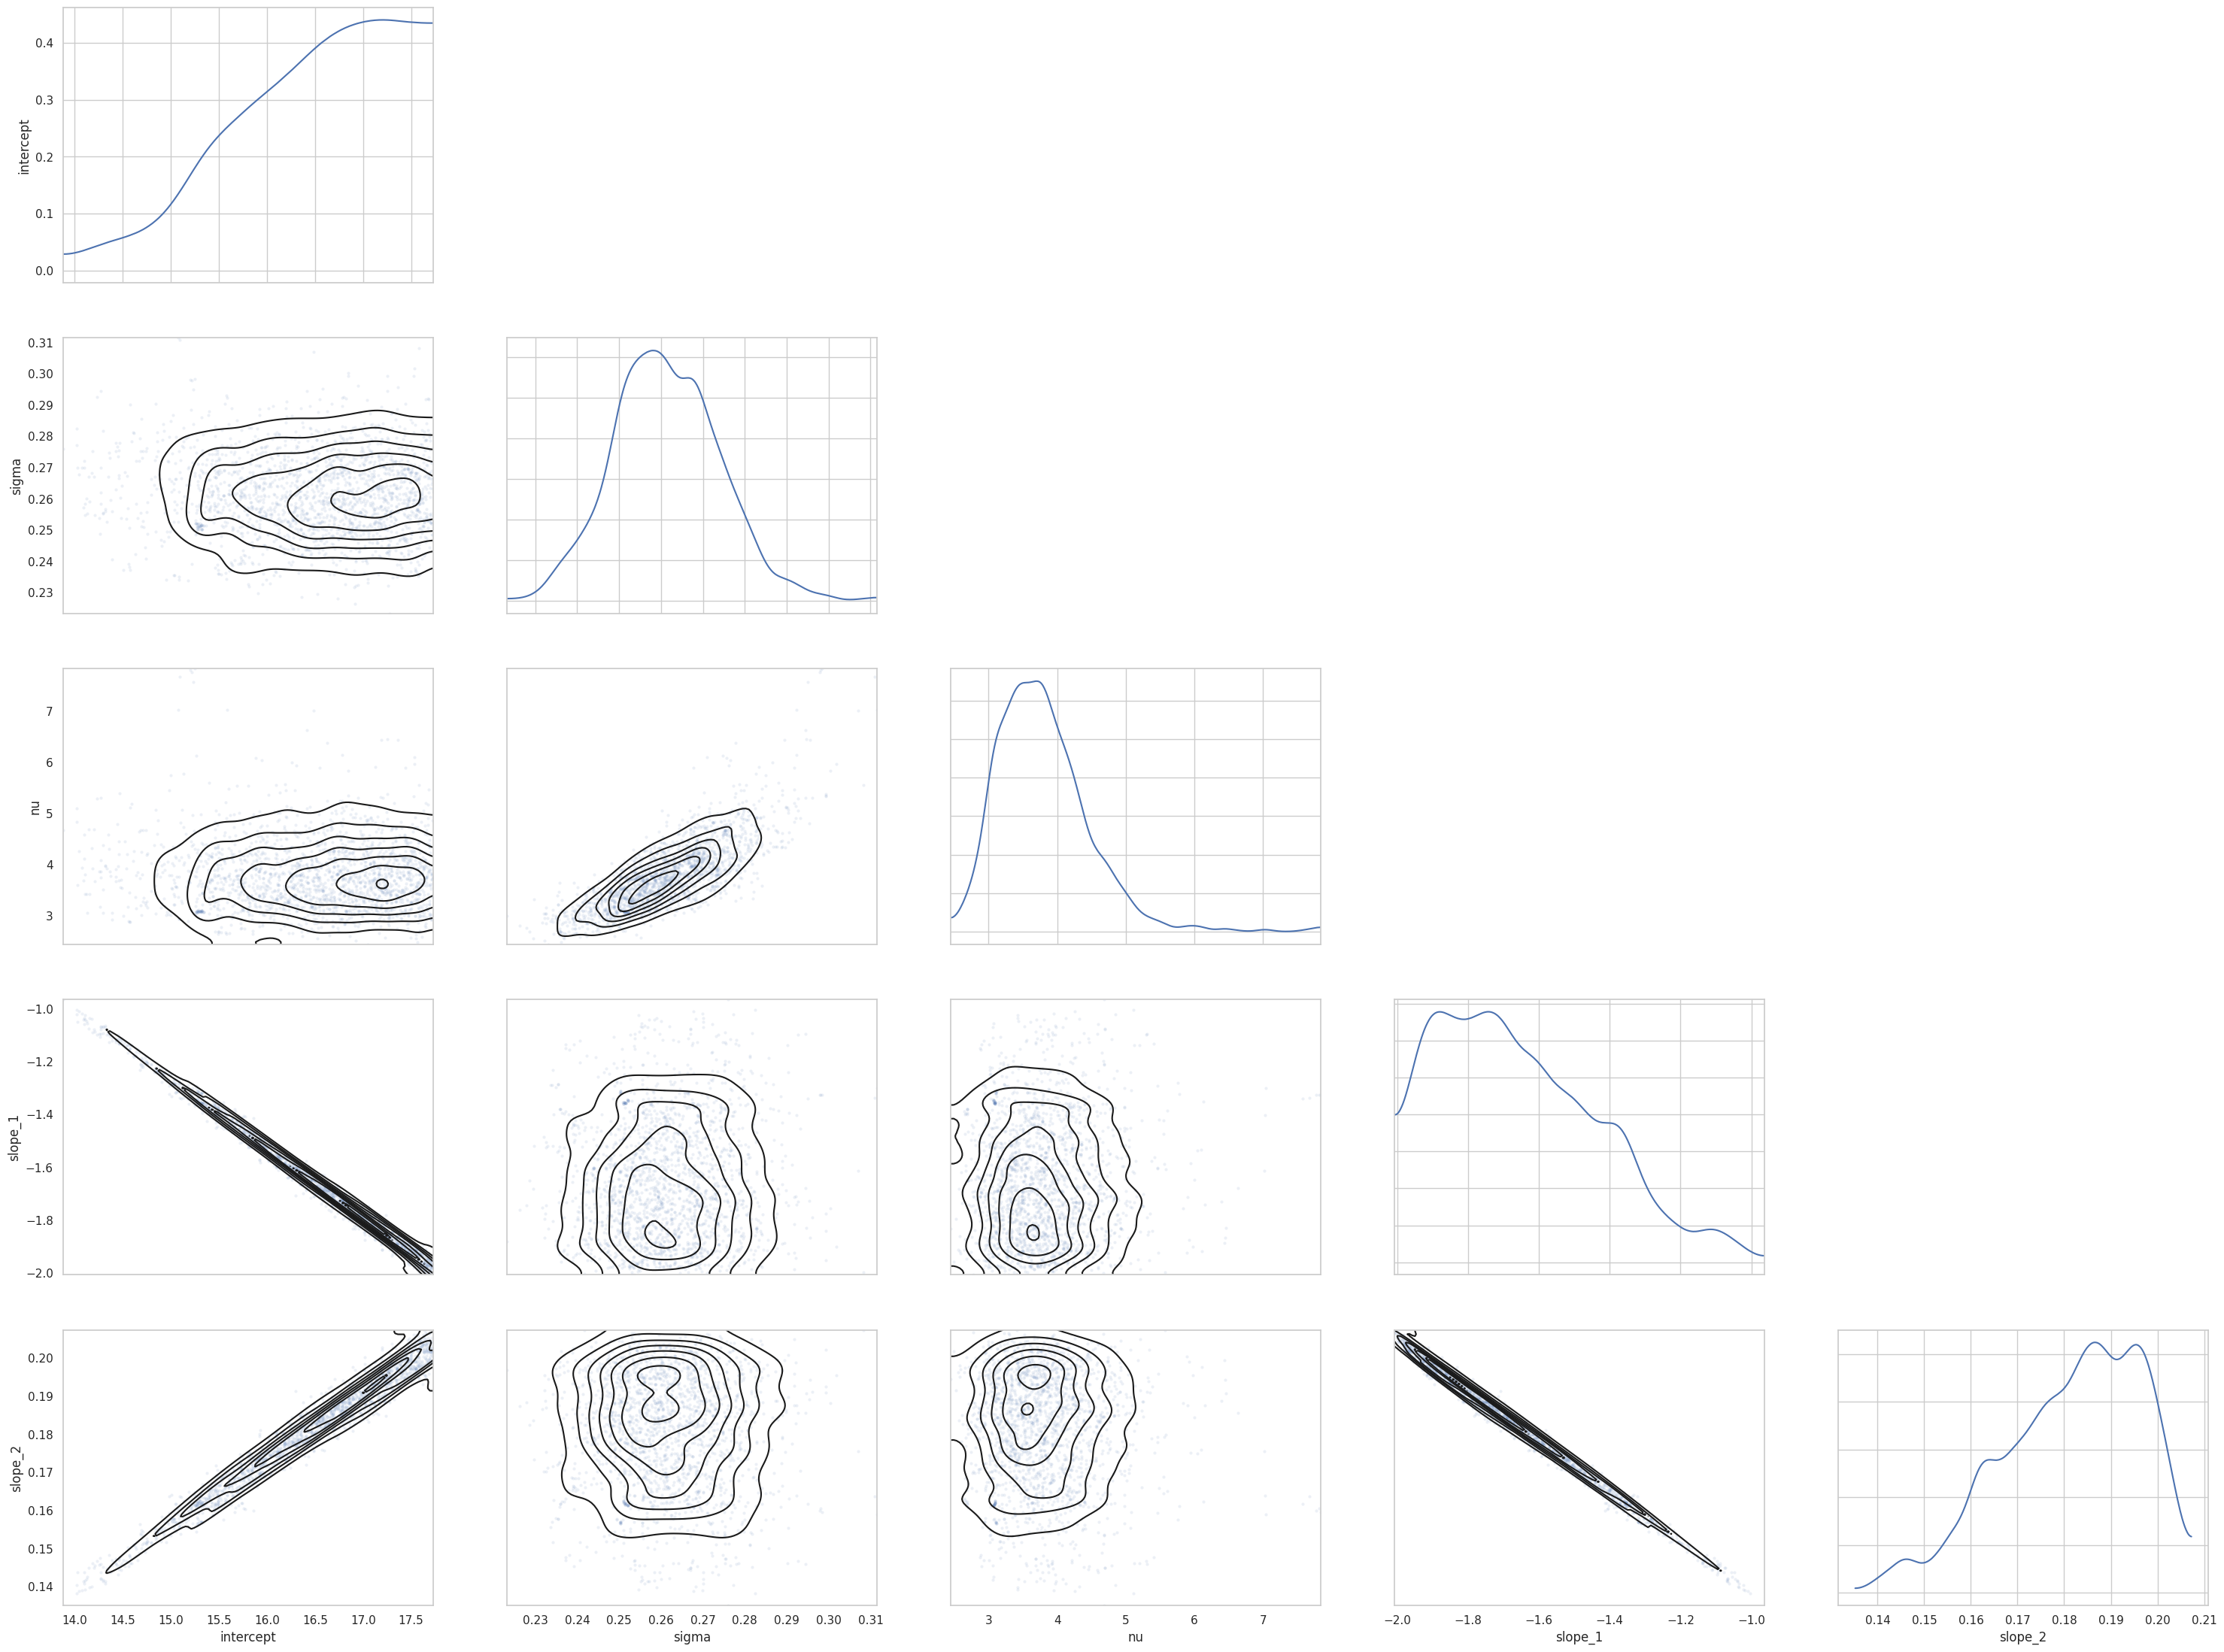

In [ ]:
# Loop through models stored in t_models for diagnostics
for degree, model, inference in t_models:
    print(f"Model Degree: {degree}")

    var_names = ['intercept', 'sigma', 'nu'] + [f'slope_{i}' for i in range(1, degree + 1)]

    # Plot rank
    az.plot_rank(inference, var_names=var_names)

    # Summary statistics
    summary = az.summary(inference, var_names=var_names)
    print(summary)

    # Pair plot
    az.plot_pair(inference,
                 marginals=True,
                 var_names=var_names,
                 kind=["scatter", "kde"],
                 scatter_kwargs={"color": "C0", "alpha": 0.1},
                 marginal_kwargs={"kind": "kde", "color": "C0"},
                 kde_kwargs={"contour_kwargs": {"colors": "k", 'alpha': 1}})

Sampling errors persist for Student t-distribution similar to those discussed for Normal above.

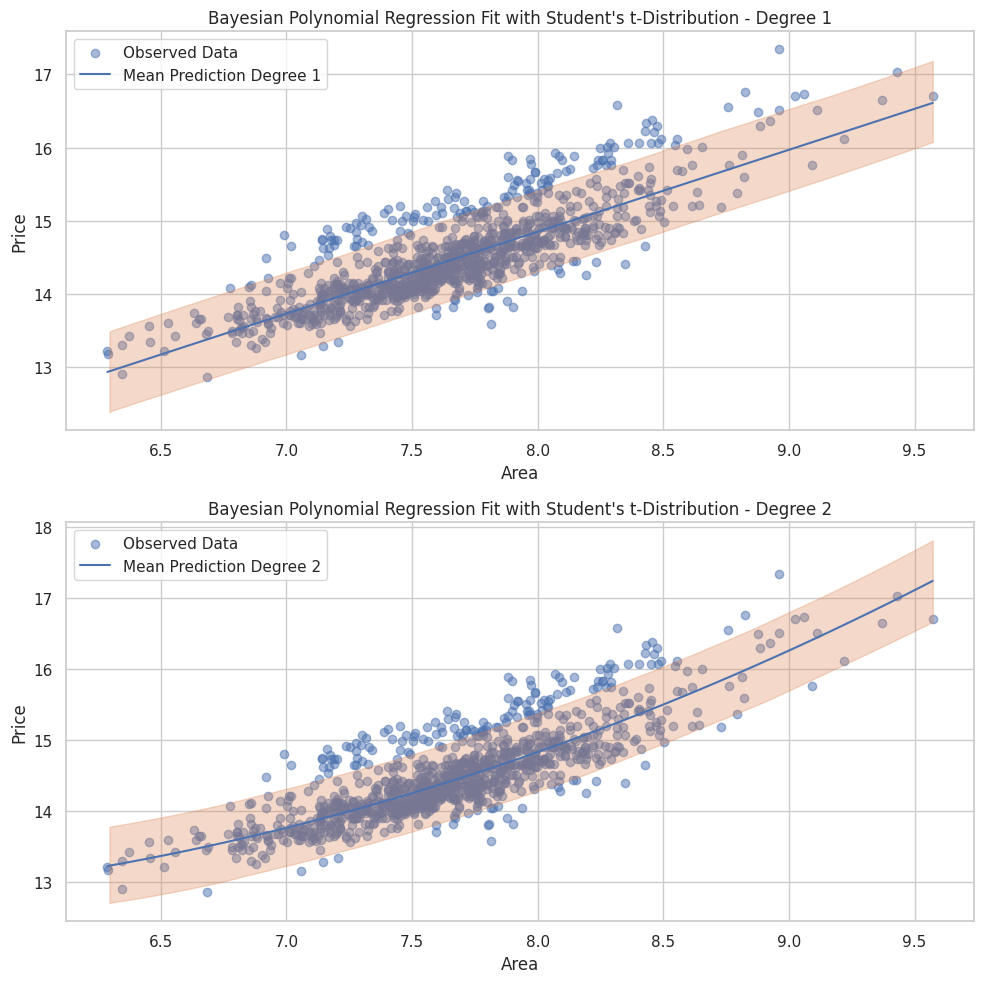

In [ ]:
# Generate a sequence of areas for plotting, covering the observed range
area_seq = np.linspace(area.min(), area.max(), 100)

# Function to calculate expected price for polynomial models with Student's t-distribution
def calculate_expected_price(degree, area_seq, inference):
    intercept_mean = inference.posterior["intercept"].mean().values.item()  # Ensure scalar
    expected_price_seq = intercept_mean
    for i in range(1, degree + 1):
        slope_mean = inference.posterior[f"slope_{i}"].mean().values.item()  # Ensure scalar
        expected_price_seq += slope_mean * np.power(area_seq, i)
    return expected_price_seq

# Determine the number of subplots needed
num_models = len(t_models)

# Create subplots
fig, axs = plt.subplots(num_models, 1, figsize=(10, 5 * num_models))

if num_models == 1:
    axs = [axs]

# Loop through stored models and inferences for plotting
for idx, (degree, model, inference) in enumerate(t_models):
    with model:
        # Generate posterior predictive checks for Student's t-distribution models
        posterior_pred = pm.sample_posterior_predictive(inference, var_names=["Y_obs"])

    expected_price_seq = calculate_expected_price(degree, area_seq, inference)

    # Plot observed data
    axs[idx].scatter(area, price, alpha=0.5, label="Observed Data")
    # Plot mean prediction for each degree
    axs[idx].plot(area_seq, expected_price_seq, label=f"Mean Prediction Degree {degree}")
    # Plot HDI for posterior predictive for the current degree model
    az.plot_hdi(area, posterior_pred.posterior_predictive["Y_obs"], hdi_prob=0.89, fill_kwargs={"alpha": 0.3}, ax=axs[idx])

    axs[idx].set_xlabel("Area")
    axs[idx].set_ylabel("Price")
    axs[idx].set_title(f"Bayesian Polynomial Regression Fit with Student's t-Distribution - Degree {degree}")
    axs[idx].legend()

plt.tight_layout()
plt.show()

In [ ]:
for degree, model, inference in t_models:
    compute_loo(model, inference)

<ipython-input-99-b0673da29fde>:15: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  az.waic(inference, scale='deviance')
<ipython-input-99-b0673da29fde>:18: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  loo_result = az.loo(inference, scale='deviance')


Computed from 2000 posterior samples and 1083 observations log-likelihood matrix.

             Estimate       SE
deviance_loo   824.01    60.88
p_loo            4.52        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     1083  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



<ipython-input-99-b0673da29fde>:15: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  az.waic(inference, scale='deviance')
<ipython-input-99-b0673da29fde>:18: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  loo_result = az.loo(inference, scale='deviance')


Computed from 2000 posterior samples and 1083 observations log-likelihood matrix.

             Estimate       SE
deviance_loo   783.14    62.80
p_loo            4.90        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     1083  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%





---



**Result**

LOOCV quantifies the discrepancy between observed outcomes and predictions made by the model, with lower values denoting better predictive capabilities. The comparison between models in our analysis yielded Deviance LOO scores of 824.01 and 783.14, respectively. The model with the Deviance LOO of 783.14 demonstrates a notably enhanced predictive accuracy, indicating a closer alignment between its predictions and the actual observed data.

**References**

Code adapted from:


- Linear Regression, "Robust Linear Regression", Session 8, PCW
- Metrics: CS146, "Model Comparison", Session 12, PCW